In [1]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

Firstly, let's define a function to perform [AdaM](https://arxiv.org/abs/1412.6980) updates...

In [2]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## 1.  [Perturbative Black Box Variational Inference](https://arxiv.org/abs/1709.07433)
#### by [Robert Bamler](https://robamler.github.io/), [Cheng Zhang](https://cheng-zhang.org/), [Manfred Opper](http://www.ki.tu-berlin.de/menue/team/manfred_opper/forschungsgebiete/), and [Stephan Mandt](http://www.stephanmandt.com/)

*Perturbative black box variational inference* (PBBVI) considers performing variational inference via maximizing: $$ \mathcal{L}_{\text{PBBVI}} = \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ f(e^{- V(\boldsymbol{\theta}; \boldsymbol{\phi})})]$$ where $ V(\boldsymbol{\theta}; \boldsymbol{\phi}) = -\log p(\mathbf{X}, \boldsymbol{\theta}) + \log q(\boldsymbol{\theta}; \boldsymbol{\phi})$, $\boldsymbol{\theta}$ are the model parameters, and $\boldsymbol{\phi}$ are the variational parameters.  When $f$ is the identity function, the objective [estimates the model evidence exactly](https://arxiv.org/abs/1509.00519) (i.e. $p(\mathbf{X}) = \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ e^{- V(\boldsymbol{\theta}; \boldsymbol{\phi})}]$), and when $f$ is $\log$, then the [*evidence lower bound* (ELBO)](http://www.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf) is recovered (i.e. $p(\mathbf{X}) \ge \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ -V(\boldsymbol{\theta}; \boldsymbol{\phi})]$).  

Things get interesting when we consider functions between the aforementioned two, which results in an objective that (1) is tighter to the evidence than the ELBO and (2) has a Monte Carlo estimate with lower variance than the exact estimate's.  The authors propose using an odd-ordered Taylor expansion around some point $V_{0}$.  For order three, we have: $$ p(\mathbf{X}) \ \  = \ \  \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ e^{- V(\boldsymbol{\theta}; \boldsymbol{\phi})}] \ \  \ge \ \  e^{-V_{0}} \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ 1 + (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi})) + \frac{1}{2} (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi}))^{2} + \frac{1}{6} (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi}))^{3} ] \ \  \ge \ \  \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ -V(\boldsymbol{\theta}; \boldsymbol{\phi})].$$  $V(\boldsymbol{\theta}; \boldsymbol{\phi})$ enters the equation polynomially, not exponentially, and thus reduces the variance of the objective's Monte Carlo estimate.  The only downside is that $V_{0}$ becomes an additional variational parameter that requires estimation.     

## 2.  Experiment: Predictive Uncertainty
We'll examine how PBBVI performs for estimating predictive uncertainty in neural network regression.  

###  Simulate Data
Let's simulate some data from a cubic function...

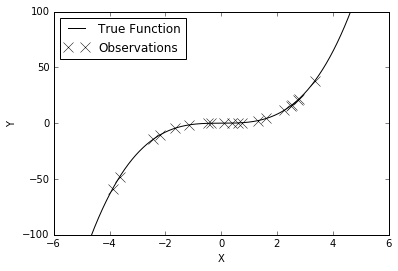

In [3]:
# Simulate data
N = 20
x = np.array([np.random.uniform(-4,4) for n in range(N)])[np.newaxis].T
y = x**3

# True function
x_true = np.linspace(start=-6, stop=6, num=1000)
y_true = x_true**3

plt.plot(x_true, y_true, 'k-', label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

###  Define Functions and Auto-Differentiate
Below we define the necessary functions (and their gradients) for a Gaussian variational approximation.  Define the model $p(\mathbf{X} | \boldsymbol{\theta})$ as a one-hidden-layer neural network with 50 units, and define the prior to be $p(\boldsymbol{\theta}) = \text{N}(\mu = 0, \sigma = .0001 )$...

In [4]:
# Gaussian prior and posterior
prior = {'mu': 0., 'sigma':.0001}

# Function for sampling from Gaussian location-scale form
def sample_from_Gauss(mu, log_sigma):
    e = np.random.normal()
    return mu + np.exp(log_sigma) * e, e

def logGaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return np.sum(np.log(1./np.sqrt(2*np.pi*params['sigma']**2)) + ((-.5/params['sigma']**2) * (x-params['mu'])**2))

# Regression NN with one hidden layer of 50 units
def logModel(W, b, x, y):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    y_hat = np.dot(h, W[:, 50:].T) + b[:, 50:]
    return np.sum( .5 * (y - y_hat)**2 )

def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    return np.dot(h, W[:, 50:].T) + b[:, 50:]

# Gauss-to-Gauss KLD
def gaussKLD(mu, log_sigma, prior_mu=prior['mu'], prior_sigma=prior['sigma']):
    kl = -np.log(prior_sigma**2)
    kl += -(np.exp(2*log_sigma) + (mu - prior_mu)**2)/(prior_sigma**2)
    kl += 2*log_sigma + 1.
    return -0.5*kl.mean()


### GET DERIVATIVES ###

# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

# d log p(\theta) / d \theta
dLogGauss_dX = grad(lambda x, mu, log_sigma: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))
dLogGauss_dMu = grad(lambda mu, x, log_sigma: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))
dLogGauss_dLogSig = grad(lambda log_sigma, x, mu: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))

# d KLD / d phi
dKLD_dmu = grad(gaussKLD)
dKLD_dLogSigma = grad(lambda p1, p2: gaussKLD(p2, p1))

###  Variational Inference via ELBO

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--via the ELBO...

In [5]:
### INIT VARIATIONAL PARAMS 
phi = {'mu': .001 * np.random.normal(size=(1,100)), 'log_sigma': .0001*np.ones((1,100)), 'b': np.zeros((1,51))}


### ELBO OPTIMIZATION
maxEpochs = 200
learning_rate = .01
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
               'log_sigma':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

n_samples = 50
for epochIdx in range(maxEpochs):
    
    elbo_val, elbo_grad_mu, elbo_grad_log_sigma, dModel_db = 0., 0., 0., 0.
    for s in range(n_samples):
        
        W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dW = dLogModel_dW(W_hat, phi['b'], x, y) 
        elbo_grad_mu += 1./n_samples * dModel_dW * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dW * rand_seed * np.exp(phi['log_sigma'])
        
        dModel_db += 1./n_samples * dLogModel_db(phi['b'], W_hat, x, y)
        elbo_val += 1./n_samples * logModel(W_hat, phi['b'], x, y)
        
    elbo_grad_mu -= dKLD_dmu(phi['mu'], phi['log_sigma'])  
    elbo_grad_log_sigma -= dKLD_dLogSigma(phi['log_sigma'], phi['mu'])
    elbo_val -= gaussKLD(phi['mu'], phi['log_sigma'])
        
    phi['mu'] += get_AdaM_update(learning_rate, elbo_grad_mu , adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, elbo_grad_log_sigma, adam_values['log_sigma']) 
    phi['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b']) 

And get an MC estimate of the predictive uncertainty...

In [6]:
n_samples = 500
predictions = []
for s in range(n_samples):
        
    W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
    y_hat = fprop(W_hat, phi['b'], x_true[np.newaxis].T)
    predictions.append(y_hat)
    
predictions = np.array(predictions)[:,:,0]
elbo_pred_mean = np.mean(predictions, axis=0)
elbo_pred_std = np.std(predictions, axis=0)

###  Variational Inference via PBBVI

Next let's fit the same Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--but via the third-order PBBVI bound.  Note we need to optimize $V_{0}$ in addition to the variational parameters...

In [7]:
### INIT VARIATIONAL PARAMS 
phi = {'mu': .001 * np.random.normal(size=(1,100)), 'log_sigma': .0001*np.ones((1,100)), 
       'V0': 0., 'b': np.zeros((1,51))}


### PBBVI OPTIMIZATION
#maxEpochs = 200
#learning_rate = .001
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
               'log_sigma':{'mean': 0., 'var': 0., 't': 0}, 
               'V0':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

n_samples = 50
for epochIdx in range(maxEpochs):
    
    negV_val, negV_grad_mu, negV_grad_log_sigma, dModel_db = 0., 0., 0., 0.
    for s in range(n_samples):
        
        W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dW = dLogModel_dW(W_hat, phi['b'], x, y) 
        negV_grad_mu += 1./n_samples * ((dModel_dW + dLogGauss_dX(W_hat, prior['mu'], np.log(prior['sigma']))) * 1. \
                                        - dLogGauss_dMu(phi['mu'], W_hat, phi['log_sigma']))
        negV_grad_log_sigma += 1./n_samples * ((dModel_dW + dLogGauss_dX(W_hat, prior['mu'], np.log(prior['sigma']))) * rand_seed * np.exp(phi['log_sigma']) \
                                               - dLogGauss_dLogSig(phi['log_sigma'], W_hat, phi['mu']))
        
        dModel_db += 1./n_samples * dLogModel_db(phi['b'], W_hat, x, y)
        
        negV_val += 1./n_samples * (logModel(W_hat, phi['b'], x, y) \
                                    + logGaussPdf(W_hat, prior) \
                                    - logGaussPdf(W_hat, {'mu': phi['mu'], 'sigma': np.exp(phi['log_sigma'])}))
        
    
    # gradient for V0: \tilde L / V0 - \tilde V0 (see Section 3.2)
    tilde_L = 1 + (phi['V0'] + negV_val) + 1./2 * (phi['V0'] + negV_val)**2 + 1./6 * (phi['V0'] + negV_val)**3
    dtildeL_dV0 = 1 + (phi['V0'] + negV_val) + 1./2 * (phi['V0'] + negV_val)**2
    ppvi_grad_V0 = dtildeL_dV0 - tilde_L
    
    # gradient for \mu and \log_sigma
    ppvi_grad_mu = negV_grad_mu + (phi['V0'] + negV_val) * negV_grad_mu + .5 * (phi['V0'] + negV_val)**2 * negV_grad_mu
    ppvi_grad_log_sigma = negV_grad_log_sigma + (phi['V0'] + negV_val) * negV_grad_log_sigma + .5 * (phi['V0'] + negV_val)**2 * negV_grad_log_sigma
        
    phi['mu'] += get_AdaM_update(learning_rate, ppvi_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, ppvi_grad_log_sigma, adam_values['log_sigma']) 
    phi['V0'] += get_AdaM_update(learning_rate, ppvi_grad_V0, adam_values['V0'])
    phi['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b']) 

And get an MC estimate of the predictive uncertainty...

In [8]:
n_samples = 500
predictions = []
for s in range(n_samples):
        
    W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
    y_hat = fprop(W_hat, phi['b'], x_true[np.newaxis].T)
    predictions.append(y_hat)
    
predictions = np.array(predictions)[:,:,0]
pbbvi_pred_mean = np.mean(predictions, axis=0)
pbbvi_pred_std = np.std(predictions, axis=0)

###  Results
Lastly, let's visualize the uncertainty bands...

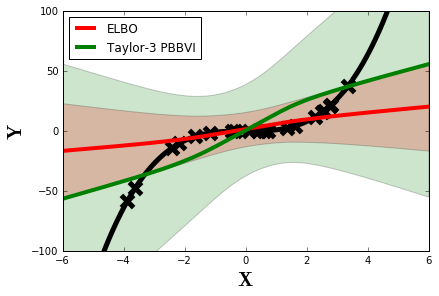

In [10]:
### Plotting ###    
plt.fill_between(x_true, pbbvi_pred_mean-pbbvi_pred_std, pbbvi_pred_mean+pbbvi_pred_std, facecolor='green', interpolate=True, alpha=.2)
plt.fill_between(x_true, elbo_pred_mean-elbo_pred_std, elbo_pred_mean+elbo_pred_std, facecolor='red', interpolate=True, alpha=.2)
plt.scatter(x, y, s=150, c='k', marker='x', linewidths=5)
plt.plot(x_true, y_true, '-k', linewidth=5.)
plt.plot(x_true, elbo_pred_mean, 'r-', linewidth=4., label="ELBO")
plt.plot(x_true, pbbvi_pred_mean, 'g-', linewidth=4., label="Taylor-3 PBBVI")

plt.xlim([-6, 6])
plt.ylim([-100, 100])
plt.ylabel(r"$\mathbf{Y}$", fontsize=20)
plt.xlabel(r"$\mathbf{X}$", fontsize=20)

plt.legend(loc=2)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

We see that, indeed, PBBVI seems to learn a more mass-covering fit than the ELBO, resulting in its larger uncertainty bands.